<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma"> Transfer Learning - Part 2</h1>

# Transfer Learning - Part 2

<div style="direction:rtl;text-align:right;font-family:Tahoma">
در این نوت بوک Fine Tuning بررسی خواهد شد.
</div>

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
74s - loss: 0.4465 - acc: 0.7810 - val_loss: 0.2056 - val_acc: 0.9120
Epoch 2/30
72s - loss: 0.2738 - acc: 0.8905 - val_loss: 0.1239 - val_acc: 0.9550
Epoch 3/30
72s - loss: 0.2088 - acc: 0.9145 - val_loss: 0.1194 - val_acc: 0.9560
Epoch 4/30
72s - loss: 0.1835 - acc: 0.9280 - val_loss: 0.1025 - val_acc: 0.9550
Epoch 5/30
72s - loss: 0.1642 - acc: 0.9330 - val_loss: 0.0903 - val_acc: 0.9680
Epoch 6/30
72s - loss: 0.1360 - acc: 0.9410 - val_loss: 0.0794 - val_acc: 0.9740
Epoch 7/30
72s - loss: 0.1426 - acc: 0.9465 - val_loss: 0.0968 - val_acc: 0.9560
Epoch 8/30
72s - loss: 0.1013 - acc: 0.9580 - val_loss: 0.1411 - val_acc: 0.9430
Epoch 9/30
72s - loss: 0.1177 - acc: 0.9500 - val_loss: 0.2105 - val_acc: 0.9310
Epoch 10/30
72s - loss: 0.0949 - acc: 0.9620 - val_loss: 0.0900 - val_acc: 0.9710
Epoch 11/30
72s - loss: 0.0915 - acc: 0.9655 - val_loss: 0.1204 - val_acc: 0.9630
Epoch 12/30
72s - loss:

In [14]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

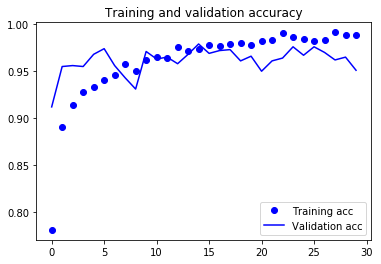

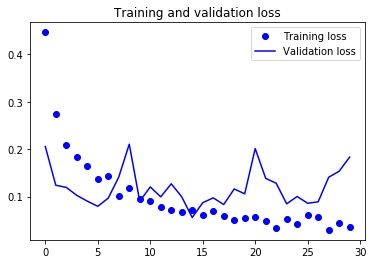

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [17]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [18]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 32s - loss: 0.0215 - acc: 0.9935 - val_loss: 0.0980 - val_acc: 0.9720
Epoch 2/100
100/100 [==============================] - 32s - loss: 0.0131 - acc: 0.9960 - val_loss: 0.1247 - val_acc: 0.9700
Epoch 3/100
100/100 [==============================] - 32s - loss: 0.0140 - acc: 0.9940 - val_loss: 0.1044 - val_acc: 0.9790
Epoch 4/100
100/100 [==============================] - 33s - loss: 0.0102 - acc: 0.9965 - val_loss: 0.1259 - val_acc: 0.9770
Epoch 5/100
100/100 [==============================] - 33s - loss: 0.0137 - acc: 0.9945 - val_loss: 0.1036 - val_acc: 0.9800
Epoch 6/100
100/100 [==============================] - 33s - loss: 0.0183 - acc: 0.9935 - val_loss: 0.1260 - val_acc: 0.9750
Epoch 7/100
100/100 [==============================] - 33s - loss: 0.0141 - acc: 0.9945 - val_loss: 0.1575 - val_acc: 0.9690
Epoch 8/100
100/100 [==============================] - 33s - loss: 0.0094 - acc: 0.9965 - val_loss: 0.0935 - val_acc: 0.9780


In [20]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

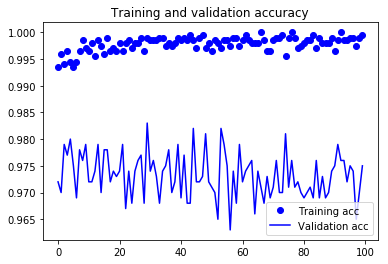

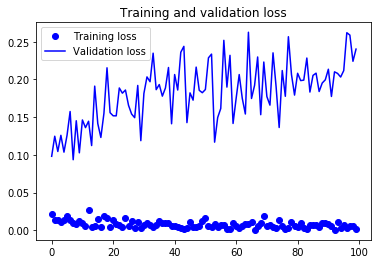

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

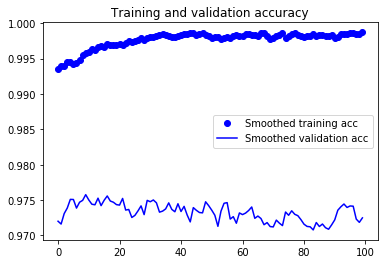

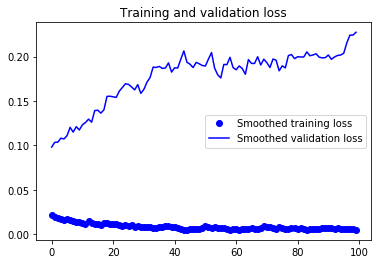

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [27]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.967999992371



Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دوره مقدماتی یادگیری عمیق<br>علیرضا اخوان پور<br>  23 و 30 آبان 1397<br>
</div>
<a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a> - <a href="https://github.com/Alireza-Akhavan/">GitHub</a>

</div>